In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

----------- ----- Visual of Orignal Data ------------

In [58]:
ticker = yf.Ticker('AMD')
dfAMD = ticker.history(period='5y')
dates = dfAMD.index.to_numpy()
high_prices = dfAMD['High'].to_numpy()

Plot the Historical Data

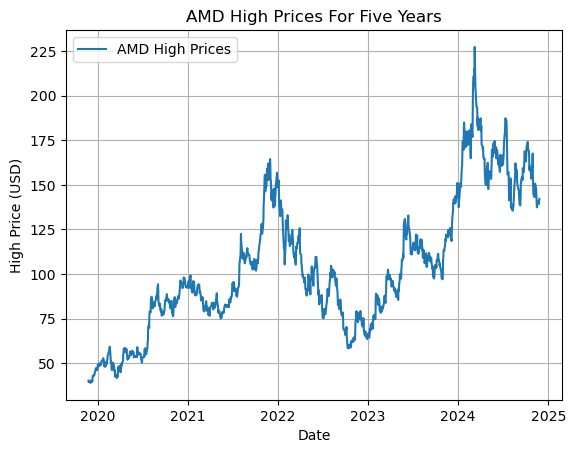

In [59]:
plt.plot(dates, high_prices, label='AMD High Prices')
plt.title('AMD High Prices For Five Years')
plt.xlabel('Date')
plt.ylabel('High Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

---------------- ADF Test to test if Data is Stationary -----------

In [60]:
result = adfuller(dfAMD['High'])
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

In [61]:
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('\nCritical Values:')
for key, value in critical_values.items():
    print(f' {key}:{value}')

ADF Statistic: -1.9214405201704452
p-value: 0.3220430023550353

Critical Values:
 1%:-3.4355629707955395
 5%:-2.863842063387667
 10%:-2.567995644141416


In [62]:
if result[1] < 0.05:
    print("Data is Stationary")
else:
    print("Not Stationary")  
# p-Value is greater than 0.05, we have to difference it

Not Stationary


--------------- Visual inspection of data using Rolling Mean & Standard Deviation----------

In [63]:
rolling_mean = dfAMD['High'].rolling(window=30).mean()
rolling_std = dfAMD['High'].rolling(window=30).std()

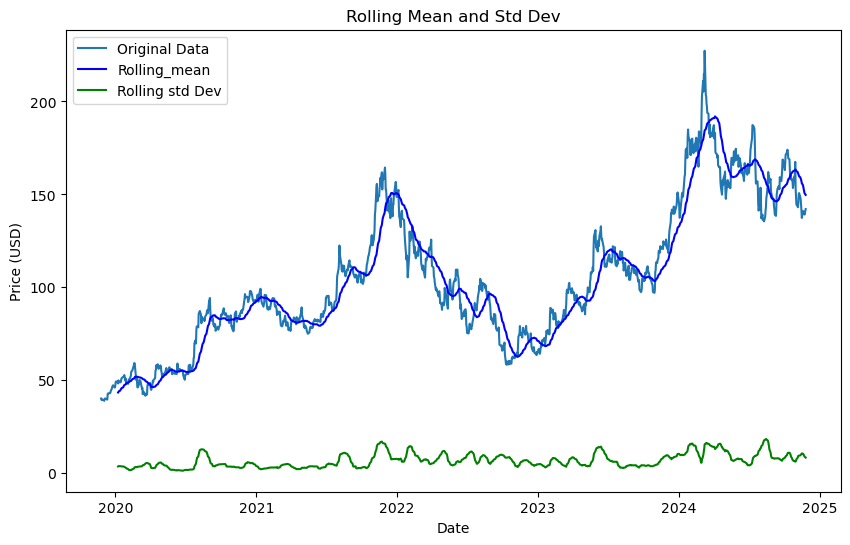

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(dfAMD['High'], label='Original Data')
plt.plot(rolling_mean, label='Rolling_mean', color='blue')
plt.plot(rolling_std, label='Rolling std Dev', color='green')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title("Rolling Mean and Std Dev")
plt.show()

--------------- Example of Differencing Data if Not Stationary ----------

In [65]:
dfAMD['diff'] = dfAMD['High'].diff()

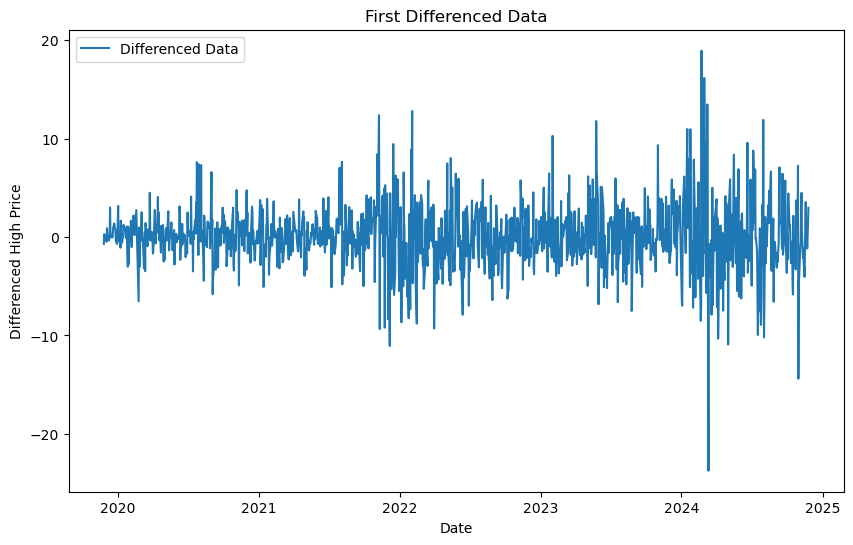

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(dfAMD['diff'], label='Differenced Data')
plt.title('First Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced High Price')
plt.legend()
plt.show()

--------------- ADF Test After Differencing ----------------

In [67]:
adf_result_diff = adfuller(dfAMD['diff'].dropna())

In [68]:
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"{key}: {value}")

ADF Statistic: -33.15816921581087
p-value: 0.0
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416


In [69]:
if adf_result_diff[1] < 0.05:
    print("Data is Stationary")
else:
    print("Data is not Stationary")

Data is Stationary


-------------- Prepare Data By Splitting into Train and Test -------

In [70]:
train_size = int(len(high_prices) * 0.90)
train = high_prices[:train_size]
test = high_prices[train_size:]

In [71]:
train_dates = dates[:train_size]
test_dates = dates[train_size:]

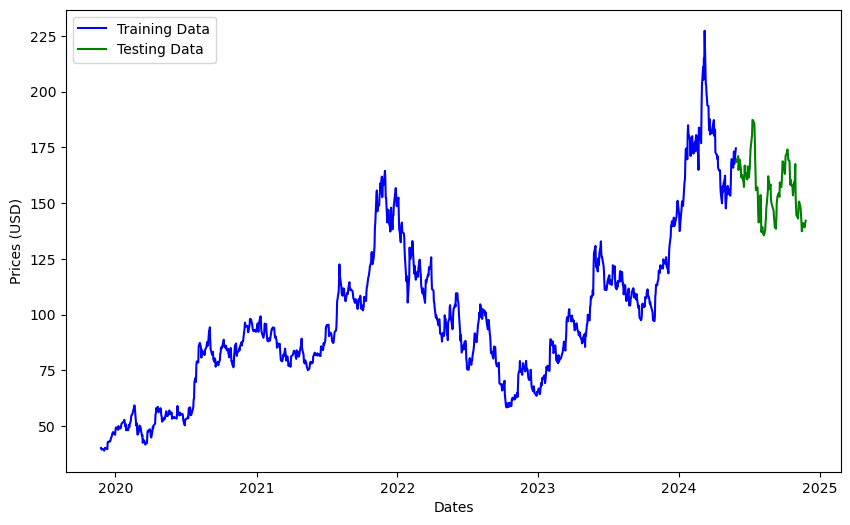

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train, label='Training Data', color='blue')
plt.plot(test_dates, test, label='Testing Data', color='green')
plt.xlabel('Dates')
plt.ylabel('Prices (USD)')
plt.legend()
plt.show()

Log Transformation 

In [73]:
log_train = np.log(train)
log_test = np.log(test)

------------- Auto-ARIMA Model for Training Data ----------------

In [74]:
auto_model = auto_arima(log_train, seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4816.568, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4813.630, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4821.840, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4821.689, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4813.336, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4819.841, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4819.840, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4817.842, Time=0.94 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4821.941, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4819.948, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4819.946, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4821.744, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4817.955, Time=1.31 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 7.144 seconds


------------- Forecasting with the ARIMA Model ------------------

In [75]:
forecast_steps = len(log_test)
forecast_log ,conf_int = auto_model.predict(n_periods=forecast_steps,return_conf_int=True )

Reverse the Log Transformation for Forecasted Data

In [76]:
forecast = np.exp(forecast_log)

Plot

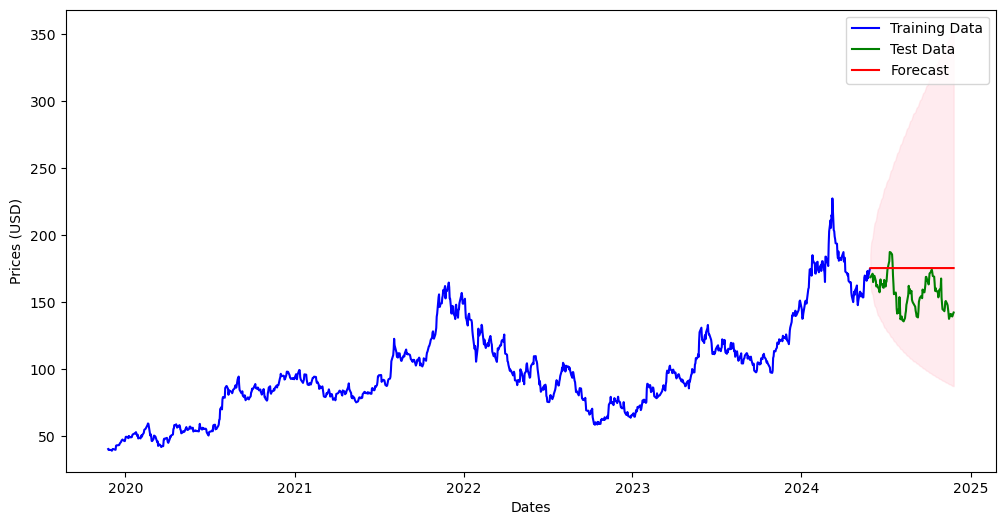

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train, label='Training Data', color='blue')
plt.plot(test_dates, test, label='Test Data', color='green')
plt.plot(test_dates, forecast, label='Forecast', color='red')
plt.fill_between(test_dates, np.exp(conf_int[:, 0]), np.exp(conf_int[:, 1]), color='pink', alpha=0.3)
plt.xlabel('Dates')
plt.ylabel('Prices (USD)')
plt.legend()
plt.show()

-------------- Calculate the Performance of the Model ----------

In [78]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) 
print(f'(MAE) on Test Data: {mae:2f}')
print(f'(MSE) on Test Data: {mse:2f}')
print(f'(RMSE) on Test Data: {rmse:2f}')
print(f'(MAPE) on Test Data: {mape:2f}') # less than 10% = excellent, 10-20%= good, greater than 20% = not good 

(MAE) on Test Data: 19.488885
(MSE) on Test Data: 495.727515
(RMSE) on Test Data: 22.264939
(MAPE) on Test Data: 0.130280


--------------- Forecasting Future Data (n Days) ---------------

In [79]:
log_high_prices = np.log(high_prices)

--------------- Fit the Auto-ARIMA Model -----------------------

In [80]:
auto_model = auto_arima(log_high_prices, seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5379.172, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5374.420, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5384.046, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5383.651, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5374.863, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5382.202, Time=1.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5382.151, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5380.233, Time=2.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5384.762, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5382.947, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5382.888, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5384.323, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5381.157, Time=2.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 12.211 seconds


Forecast Next n Days

In [81]:
forecast_steps_n = 100
forecast_log_n, conf_int_n = auto_model.predict(n_periods=forecast_steps_n, return_conf_int=True)

Reverse the Log Transformation for the Future Forecast

In [82]:
forecast_n = np.exp(forecast_log_n)
last_date = dates[-1]
forecast_dates_n = pd.date_range(start=last_date, periods=forecast_steps_n + 1, freq='B')[1:]
forecast_dates_n = np.array(forecast_dates_n)

----------------- Plot the n-Day Forecast ---------------------

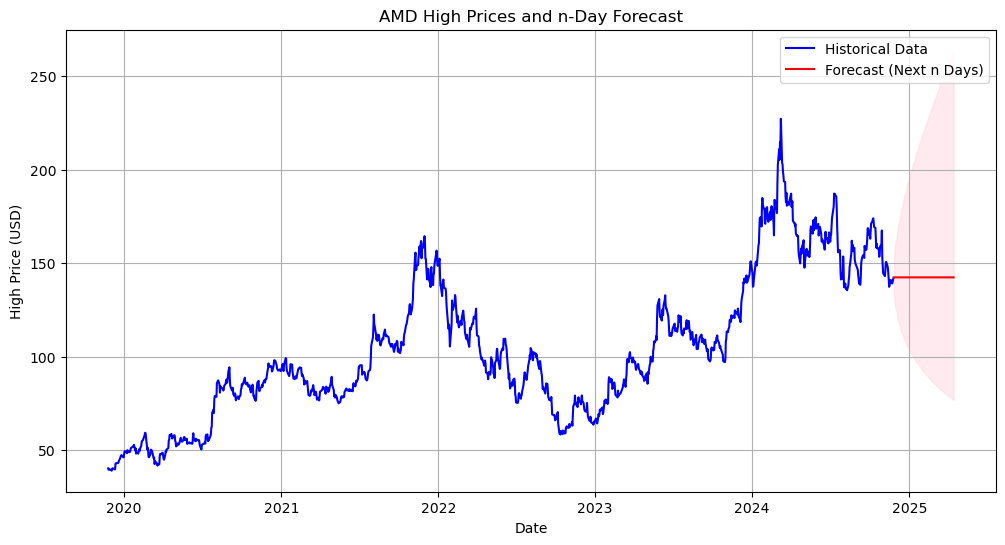

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(dates, high_prices, label='Historical Data', color='blue')
plt.plot(forecast_dates_n, forecast_n, label='Forecast (Next n Days)', color='red')
plt.fill_between(forecast_dates_n, np.exp(conf_int_n[:, 0]), np.exp(conf_int_n[:, 1]), color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('High Price (USD)')
plt.title('AMD High Prices and n-Day Forecast')
plt.legend()
plt.grid(True)
plt.show()

---------------- Forecasted Data for the Next n Days ----------

In [84]:
forecast_df_n = pd.DataFrame({'Date': forecast_dates_n, 'Predicted Price': forecast_n})
print(forecast_df_n)

                        Date  Predicted Price
0  2024-11-26 00:00:00-05:00       142.391673
1  2024-11-27 00:00:00-05:00       142.420018
2  2024-11-28 00:00:00-05:00       142.422770
3  2024-11-29 00:00:00-05:00       142.423037
4  2024-12-02 00:00:00-05:00       142.423063
..                       ...              ...
95 2025-04-08 00:00:00-04:00       142.423066
96 2025-04-09 00:00:00-04:00       142.423066
97 2025-04-10 00:00:00-04:00       142.423066
98 2025-04-11 00:00:00-04:00       142.423066
99 2025-04-14 00:00:00-04:00       142.423066

[100 rows x 2 columns]


In [ ]:
#df.to_csv("forecast_df_n.csv", index=False)
#print("\nResults saved to 'forecast_df_n.csv'.")